In [127]:
import numpy as np
import matplotlib.pyplot as plt
import getdist
from getdist import plots, MCSamples
%matplotlib inline

import scipy as sp

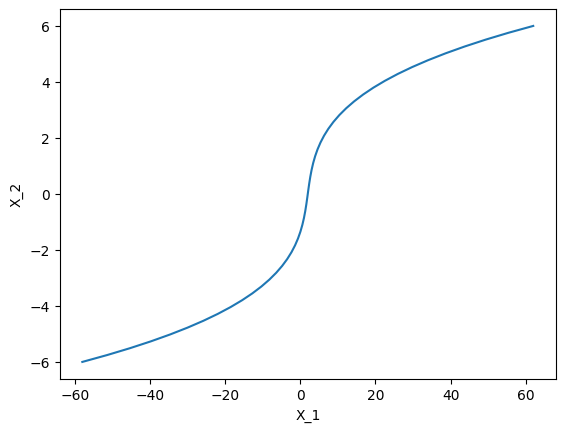

In [128]:
def model(theta):
    return np.array([2+2*theta+2*theta**3,2*theta])

def deriv_model(theta):
    return np.array([2+2*3*theta**2,2])

Theta=np.linspace(-3,3,50)
plt.plot(model(Theta)[0],model(Theta)[1])

plt.xlabel('X_1')
plt.ylabel('X_2')

plt.show()

In [129]:
mean_prior=0
sig_prior=1
sigma_likelihood=0.3
n_samples=1
cov = np.eye(2) * sigma_likelihood**2

all_samples = np.empty((0, 2))
for j in range(10000):
    theta0 = np.random.normal(mean_prior,sig_prior)
    X_0=model(theta0)
    mean = X_0
    
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    all_samples = np.vstack((all_samples, samples))



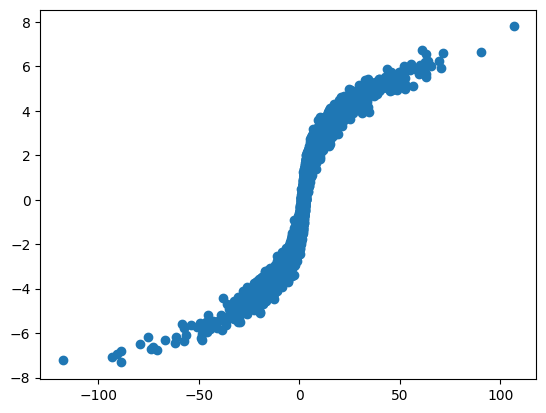

In [130]:
plt.scatter(all_samples[:,0],all_samples[:,1])

In [131]:
def model_linear(theta,theta_0,model):
    M=deriv_model(theta_0)
    return model(theta_0)+M*(theta-theta_0)



In [132]:
model_linear(theta=0.5,theta_0=mean_prior,model=model)

array([3., 1.])

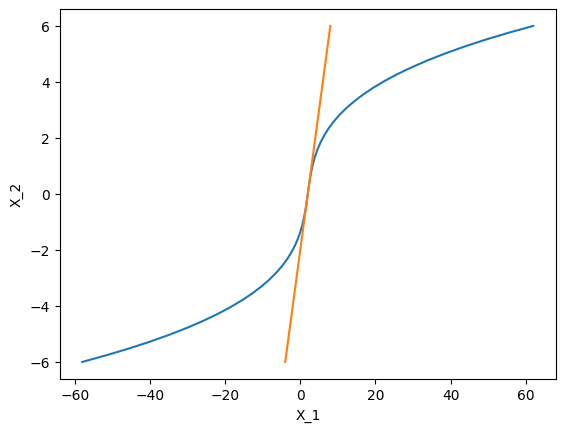

In [133]:
Theta=np.linspace(-3,3,50)
plt.plot(model(Theta)[0],model(Theta)[1])
model_linear_vec=np.array([model_linear(theta,mean_prior,model) for theta in Theta])

plt.plot(model_linear_vec[:,0],model_linear_vec[:,1])

plt.xlabel('X_1')
plt.ylabel('X_2')

plt.show()

In [134]:
model(0)

array([2, 0])

In [135]:
all_samples.shape

(10000, 2)

In [136]:
# define the M matrix
M = deriv_model(mean_prior)

# define the covariance matrix of the data
sigma = np.cov(all_samples.T)
print("Covariance matrix of the data shape:\n", sigma.shape)

#define its inverse
sigma_inv = np.linalg.inv(sigma)

# define the prior mean and covariance
prior_mean = np.array([2, 0])
prior_cov = sig_prior**2

# define the prior covariance matrix inverse
prior_cov_inv = 1/prior_cov

Covariance matrix of the data shape:
 (2, 2)


In [158]:
sigma, cov

(array([[86.87006424, 16.05808361],
        [16.05808361,  4.13067129]]),
 array([[0.09, 0.  ],
        [0.  , 0.09]]))

In [137]:
all_samples, all_samples.shape, M.shape, sigma_inv.shape

(array([[-6.83222081, -2.97199452],
        [-2.38459766, -1.86860563],
        [ 1.25167745, -1.04815456],
        ...,
        [-1.93851388, -1.80881506],
        [ 0.11301245, -1.3510436 ],
        [ 4.3785997 ,  1.39819188]]),
 (10000, 2),
 (2,),
 (2, 2))

In [138]:
# define the Mtilde matrix
Mtilde = (M.T @ sigma_inv @ M)**(-1) * (M.T @ sigma_inv)
print('Mtilde:', Mtilde)

Mtilde: [-0.10127791  0.60127791]


In [139]:
#check properties of Mtilde
print('Mtilde@M :', Mtilde @ M)
print(Mtilde.T == sigma_inv@M * (M.T @ sigma_inv @ M)**(-1))

Mtilde@M : 0.9999999999999999
[ True  True]


In [140]:
#define the projector 
P = np.outer(M,Mtilde)
print('P:', P)

#define the complement of the projector
P_complement = np.eye(2) - P
print('P_complement:', P_complement)

P: [[-0.20255583  1.20255583]
 [-0.20255583  1.20255583]]
P_complement: [[ 1.20255583 -1.20255583]
 [ 0.20255583 -0.20255583]]


In [141]:
P_complement @ M == M

array([False, False])

In [142]:
P @ M , M

(array([2., 2.]), array([2, 2]))

In [143]:
P@P == P

array([[False,  True],
       [False,  True]])

In [144]:
(P_complement.T) @ sigma_inv @ P #should give 0

array([[-6.20761209e-18,  3.92803826e-17],
       [-6.38187406e-18,  3.79275531e-17]])

In [145]:
P_complement.shape, (all_samples - model(mean_prior)).shape

((2, 2), (10000, 2))

In [146]:
diff = (all_samples - model(mean_prior)).T
print('diff shape:', diff.shape)

diff shape: (2, 10000)


In [147]:
def getLmax(diff):
    return np.exp(-0.5* diff.T @ P_complement.T @ sigma_inv @ P_complement @ diff)/ np.sqrt(np.linalg.det(2*np.pi*sigma))

In [148]:
Lmax_value = getLmax(diff[:,0]) 
print('Lmax value for first sample:', Lmax_value)

Lmax value for first sample: 0.011832639384502653


In [149]:
Lmax = np.array([getLmax(diff[:,i]) for i in range(diff.shape[1])])
print('Lmax shape:', Lmax.shape)

Lmax shape: (10000,)


In [150]:
thetaML = mean_prior + Mtilde @ diff
print(thetaML.shape)

(10000,)


In [151]:
Cinv = (M.T @ sigma_inv @ M)
print('Cinv:', Cinv)
C = 1/Cinv

Cinv: 2.3327635303017664


In [152]:
L = Lmax* np.exp(-0.5 * np.matmul((thetaML - mean_prior).T, Cinv * (thetaML - mean_prior)) )

In [153]:
L.shape

(10000,)

In [154]:
prior_cov, C

(1, np.float64(0.42867611183489307))

In [155]:
logEvidence = np.log(Lmax)+0.5 *np.log(abs(C)/abs(C+prior_cov))- 0.5 * np.matmul((thetaML - mean_prior).T, 1/(C + prior_cov) * (thetaML - mean_prior))

In [156]:
logEvidence.shape

(10000,)

Text(0, 0.5, 'X_2')

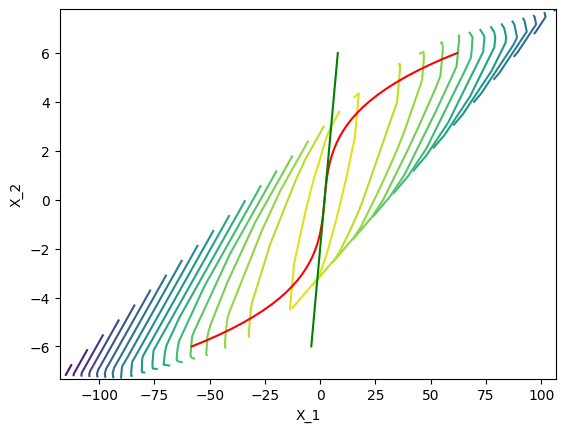

In [157]:
plt.tricontour(all_samples[:,0], all_samples[:,1], logEvidence, levels=20)
plt.plot(model(Theta)[0], model(Theta)[1], color='red', label='Model')
plt.plot(model_linear_vec[:,0], model_linear_vec[:,1], color='green', label='Linear Approximation')
plt.xlabel('X_1')
plt.ylabel('X_2')